### Problem 1

In [37]:
def fib(max):
    n, a, b = 0, 0, 1
    while n < max:
        # print(b)
        yield b

        a, b = b, a + b
        #a, b = b, a + b相当于a=b,b=a+b

        n = n + 1
    return 'done'

In [38]:
fib_1 = list(fib(7))
print (fib_1)

[1, 1, 2, 3, 5, 8, 13]


In [39]:
import numpy as np
a1=np.array(fib_1)
a1_1 =a1[1:]
a1_2 = a1[0:-1]/a1_1
print (a1_2)

[ 1.          0.5         0.66666667  0.6         0.625       0.61538462]


### Problem2 Pandas与Numpy操作

##### 2_1  读取sz50.xlsx的['600036.XSHG','600050.XSHG','601318.XSHG']的全数据做成Panel

In [40]:
from datetime import datetime
import pandas as pd
symbol =['600036.XSHG','600050.XSHG','601318.XSHG']
data_dict ={}
for s in symbol:
 data = pd.read_excel('sz50.xlsx',sheetname=s,index_col = 'datetime')
 # data_dict[s] =data.loc['2017-03-21':'2017-05-10']
 data_dict[s] = data
pa = pd.Panel(data_dict)
pan = pa.to_frame()
# print(round((pan.head()),1)
pa

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 215 (major_axis) x 5 (minor_axis)
Items axis: 600036.XSHG to 601318.XSHG
Major_axis axis: 2017-01-03 15:00:00 to 2017-11-20 15:00:00
Minor_axis axis: close to volume

#### 2_2 把Panel转成ndim为3的Numpy，然后用array的切片读取ndim为2的三只股票最近20天的收盘价

In [41]:
import xarray as xr
data_2 = xr.DataArray(pa)
data_2arr = data_2.values # ndim = 3
data_2arry = np.array(data_2arr)
data_20days = data_2arry[:][0:20][2] # ndim = 2
data_20days

array([[  7.98900000e+01,   8.06500000e+01,   7.91100000e+01,
          7.91500000e+01,   2.96870990e+07],
       [  7.98700000e+01,   8.01600000e+01,   7.95300000e+01,
          7.99400000e+01,   2.52573050e+07],
       [  8.00200000e+01,   8.05000000e+01,   7.99100000e+01,
          8.00200000e+01,   2.86895330e+07],
       ..., 
       [  1.63520000e+02,   1.63720000e+02,   1.54320000e+02,
          1.54470000e+02,   5.84197000e+07],
       [  1.68580000e+02,   1.68690000e+02,   1.60970000e+02,
          1.62690000e+02,   7.71057000e+07],
       [  1.69570000e+02,   1.71270000e+02,   1.66190000e+02,
          1.67460000e+02,   5.55280000e+07]])

## 2_3 计算20天收盘价的对数，然后求对数的一天差值，得到对数收益率


In [42]:
# https://blog.csdn.net/u014281392/article/details/73522237
#  首先要如除掉datafram 中无效的股票名称
#  取前20 天
data_20 =  data.iloc[0:20,:]

In [43]:
data['log_market'] = np.log(data_20['close']/data_20['close'].shift(1)) # 这里的对数收益不是array

#### 还没有做 2.4 这里的题目是只需要三只股票的价格和计算

## 3. 用pandas计算滚动的协方差图表显示出来

#### 用Pandas计算3只股票的三天收益率

In [52]:
import pandas as pd
stock1 = pd.read_excel('sz50.xlsx',sheetname='600036.XSHG', index_col='datetime')
stock2 = pd.read_excel('sz50.xlsx',sheetname='600050.XSHG', index_col='datetime')
stock3 = pd.read_excel('sz50.xlsx',sheetname='601318.XSHG', index_col='datetime')
# three_day_change = stock1.close.pct_change(3) # 3 天的收益率函数
three_day_df = pd.concat([stock1.close.pct_change(3),stock2.close.pct_change(3),stock3.close.pct_change(3)],keys=['stock1','stock2','stock3'],axis=1)

In [45]:
print(three_day_df.tail())

                       stock1    stock2    stock3
datetime                                         
2017-11-14 15:00:00  0.035086 -0.041414  0.061659
2017-11-15 15:00:00  0.029902 -0.029087 -0.009838
2017-11-16 15:00:00  0.015578 -0.035141  0.040733
2017-11-17 15:00:00  0.048565  0.014752  0.068856
2017-11-20 15:00:00  0.095011  0.012397  0.094071


### 3_2. 计算滚动窗口为5（NaN需要填满）的协方差

In [85]:
cov_3 = three_day_df.rolling(5).cov()
# cov_3_1 = cov_3.fillna(method='bfill')
where_are_nan = np.isnan(cov_3) 
cov_3[where_are_nan] = 0 # 将NaN 填满 为 0 

In [86]:
import matplotlib.pyplot as plt

In [89]:
plt.figure(figsize=(15,7))
plt.plot(cov_3.unstack()['stock1','stock2'],label='600036.XSHG and 600050.XSHG')
plt.legend()
#plt.show()

In [94]:
plt.figure(figsize=(15,7))
plt.plot(cov_3.unstack()['stock1','stock3'],label='600036.XSHG and 601318.XSHG')
plt.legend()
# plt.show()

In [93]:
plt.figure(figsize=(15,7))
plt.plot(cov_3.unstack()['stock2','stock3'],label='600050.XSHG and 601318.XSHG')
plt.legend()
# plt.show()

### 4 将日K线计算周K线并将其画出来

#### 4_1. 读取600036.XSHG的股票日线

In [102]:
# 聚合
stock1 = pd.read_excel('sz50.xlsx',sheetname='600036.XSHG', index_col='datetime')
# https://www.zhihu.com/question/61607343/answer/189318262

In [103]:
#### 4_2 利用正确的方法将日K线聚合成周K线

In [121]:
# resample成周线后用agg获取所需要的数据
k_week_stocks = stock1.resample('W').agg({'high':'max','low':'min', 'close':'last', 'open':'first'})
from matplotlib.pylab import date2num
k_week_stocks ['time'] = list(map(date2num, k_week_stocks.index))
k_week_stocks = k_week_stocks.reindex_axis(["time", "open", "high", "low", "close"], 1).values

In [122]:
import matplotlib.finance as mpf

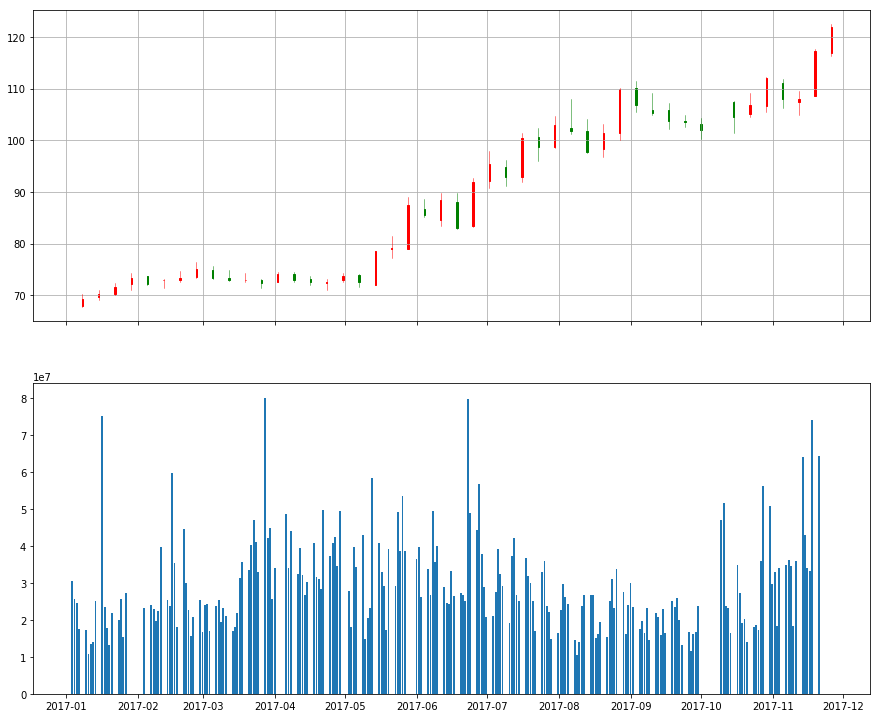

In [124]:
fig, (ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,25))
fig.subplots_adjust(bottom=0.5)
ax.grid(True)
mpf.candlestick_ohlc(ax, k_week_stocks, width=0.6, colorup='r', colordown='g',alpha=1.0)
ax1.bar(stock1.index,stock1.volume)
ax.xaxis_date ()
plt.show()

### 5 用Pandas的递归函数计算EMA与DEMA，对比talib的EMA与DEMA

#### 5_11. 根据以上的算法，利用Pandas的ewm方法计算600036.XSHG以10天为周期的EMA，再算出DEMA。

In [142]:
def EMA(A,n,m):
    # 设置alpha的比例
    alpha = m/n
    #通过ewm计算递归函数
    return A.ewm(alpha=alpha, adjust=False).mean()

In [148]:
EMA10 = EMA(stock1.close,11,2)

In [149]:
DEMA = 2*EMA10-EMA(EMA10,11,2)
DEMA.tail()

datetime
2017-11-14 15:00:00    109.962034
2017-11-15 15:00:00    110.542147
2017-11-16 15:00:00    111.244796
2017-11-17 15:00:00    113.433683
2017-11-20 15:00:00    116.538850
Name: close, dtype: float64

In [137]:
import talib as ta

In [138]:
DEMA_talib = ta.DEMA(stock1.close, timeperiod=10)

In [146]:
DEMA_talib.tail()

datetime
2017-11-14 15:00:00    109.962034
2017-11-15 15:00:00    110.542147
2017-11-16 15:00:00    111.244796
2017-11-17 15:00:00    113.433683
2017-11-20 15:00:00    116.538850
dtype: float64